In [1]:
model_name = "linear_tanh"
dataset_name = "regress_gaussian"

In [2]:
import train

number of parameters: 0.000105 M 
step 0: train loss 0.4302, val loss 0.3957
step 10: train loss 0.4253, val loss 0.3923
step 20: train loss 0.4050, val loss 0.3845
step 30: train loss 0.3699, val loss 0.3603
step 40: train loss 0.2061, val loss 0.2440
step 50: train loss 0.1734, val loss 0.2039
step 60: train loss 0.1628, val loss 0.1883
step 70: train loss 0.1537, val loss 0.1863
step 80: train loss 0.1361, val loss 0.1650
step 90: train loss 0.1300, val loss 0.1615
step 100: train loss 0.1161, val loss 0.1412
step 110: train loss 0.1048, val loss 0.1279
step 120: train loss 0.1052, val loss 0.1305
step 130: train loss 0.0908, val loss 0.1109
step 140: train loss 0.1024, val loss 0.1146
step 150: train loss 0.0848, val loss 0.1049
step 160: train loss 0.0785, val loss 0.0992
step 170: train loss 0.0777, val loss 0.0971
step 180: train loss 0.0774, val loss 0.1000
step 190: train loss 0.0912, val loss 0.1092
step 200: train loss 0.0829, val loss 0.1033
step 210: train loss 0.0804, val

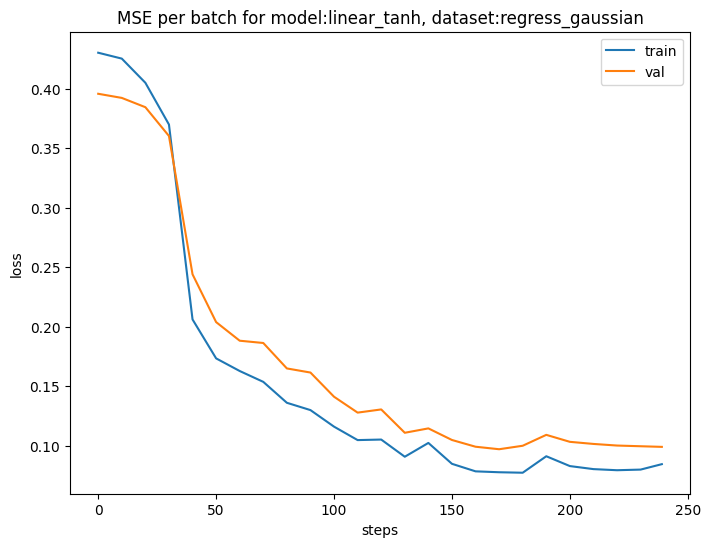

In [3]:
from draw import draw_loss
draw_loss(
    train.iter_list,
    train.train_losses, 
    train.val_losses, 
    f"MSE per batch for model:{model_name}, dataset:{dataset_name}", is_save=True
)

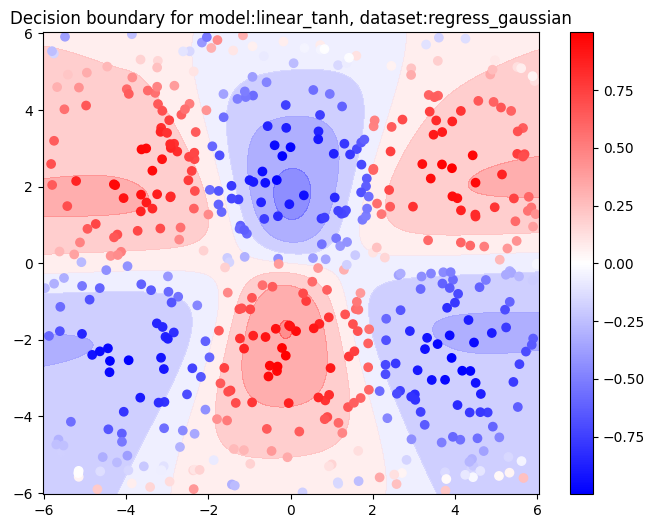

In [4]:
from draw import draw_dataset, draw_decision_boundary
# draw_dataset(train.valset, "Validation set")
draw_decision_boundary(
    train.model, 
    train.valset, 
    f"Decision boundary for model:{model_name}, dataset:{dataset_name}", 
    is_save=True
)